# Basic data manipulation and plotting examples

## Preliminaries

In [1]:
# Imports

import numpy as np

# Astropy 
from astropy.io import fits           # To read fits files
from astropy.cosmology import WMAP7   # For the WMAP7 cosmology used in Guo2010a
import astropy.constants as c
import astropy.units as u

# Plots graphics within the notebook:
import matplotlib.pyplot as plt
%matplotlib inline            

# Makes nice plots
import seaborn as sns

In [2]:
# Parameters

# Data location
dataFile='milliMil.fits'

# Simulation parameters (ideally should be read from metadata)
hubble=WMAP7.H(0)/(100*u.km/(u.s*u.Mpc))   # Dimensionless hubble parameter, h
rhoc=WMAP7.critical_density(0)             # Critical density (units included)
mumH=1e-27*u.kg                            # Mean mass per particle in hot gas
boxside=62.5             # Mpc/h
massUnit=1e10            # Msun/h
odVir=200                # "Virial" overdensity in Guo2010a (not real virial od)

# Plotting style
sns.set()
sns.set_context('notebook',font_scale=1.5)
sns.set_style('whitegrid')

In [3]:
# Read in fits file and examine data
# Open the file
hdulist = fits.open(dataFile)
# Read the data into a numpy record array
data = hdulist[1].data
# Close the file
hdulist.close()
# and list the columns
data.columns

ColDefs(
    name = 'type'; format = 'J'
    name = 'centralMvir'; format = 'E'
    name = 'stellarMass'; format = 'E'
    name = 'bulgeMass'; format = 'E'
    name = 'coldGas'; format = 'E'
    name = 'hotGas'; format = 'E'
    name = 'metalsStellarMass'; format = 'E'
    name = 'metalsBulgeMass'; format = 'E'
    name = 'metalsColdGas'; format = 'E'
    name = 'metalsHotGas'; format = 'E'
    name = 'blackHoleMass'; format = 'E'
    name = 'sfr'; format = 'E'
    name = 'massWeightedAge'; format = 'E'
    name = 'xrayLum'; format = 'E'
    name = 'u_mag'; format = 'E'
    name = 'g_mag'; format = 'E'
    name = 'r_mag'; format = 'E'
    name = 'i_mag'; format = 'E'
    name = 'z_mag'; format = 'E'
    name = 'uDust'; format = 'E'
    name = 'gDust'; format = 'E'
    name = 'rDust'; format = 'E'
    name = 'iDust'; format = 'E'
    name = 'zDust'; format = 'E'
)

## BH-bulge mass relation

An example of a scatter plot.


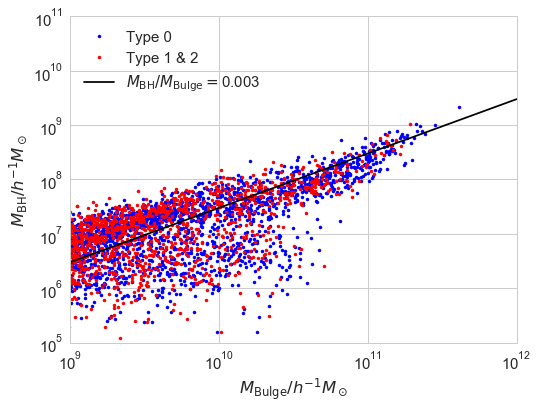

In [4]:
# Plotting parameters
xmin=1e9
xmax=1e12
ymin=1e5
ymax=1e11
massRatio=0.003
pltFile='BHBulge.png'

# Extract required data, converting masses to Msun/h
Type=data['type']
blackHoleMass=data['blackHoleMass']*massUnit
bulgeMass=data['bulgeMass']*massUnit

# Plot central galaxies in halos (Type==0) in blue; other galaxies in red
index0=np.where(Type==0)[0]
index12=np.where(np.logical_not(Type==0))[0]

# Create the figure
plt.figure(0,figsize=(8,6))
#
plt.loglog(bulgeMass[index0],blackHoleMass[index0],'b.',label='Type 0')
plt.loglog(bulgeMass[index12],blackHoleMass[index12],'r.',label='Type 1 & 2')
# Plot linear relation
plt.plot([xmin,xmax],[massRatio*xmin,massRatio*xmax],'k',label=r'$M_\mathrm{BH}/M_\mathrm{Bulge}=$'+str(massRatio))
# Add labels (always!)
plt.legend(loc=2)
plt.xlabel(r'$M_\mathrm{Bulge}/h^{-1}M_\odot$')
plt.ylabel(r'$M_\mathrm{BH}/h^{-1}M_\odot$')
# Set limits of plot
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
# Save results
plt.savefig(pltFile)

## Stellar mass function

An example of a histogram plot.

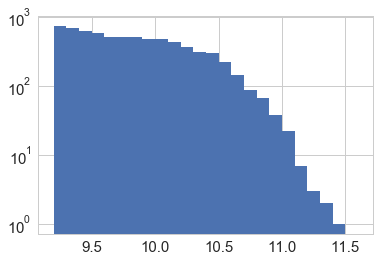

In [5]:
# Bins for histogram
binperdex=10
xrange=np.array([9.2,11.6])
nbin=int((xrange[1]-xrange[0])*binperdex+0.5)

# Plotting parameters
xmin=12.4
xmax=7.0
ymin=10**(-5.9)
ymax=10**0.5
pltFile='SMF.png'

# Observational data
obsFile='StellarMassFunction_z0.00.txt'

# Extract required data
stellarMass=data['stellarMass']*massUnit*hubble  # Units Mpc/h**2

# Put into bins and normalise to number per unit volume (Mpc/h) per dex
nobj,bins,junk=plt.hist(np.log10(stellarMass), bins=nbin, range=xrange, log=True)

# The plot below is produced by plt.hist - it is not our final result
# We could have used np.histogram instead and avoided the plot, but it's useful.

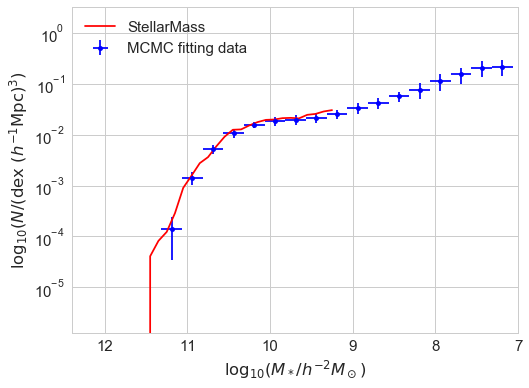

In [6]:
# Plot at centre of bins
x=0.5*(bins[:-1]+bins[1:])
# Normalise
y=nobj*binperdex/boxside**3

# Plot SMF of data
plt.figure(0,figsize=(8,6))
plt.semilogy(x,y,'-r',label='StellarMass')
plt.axis([xmin,xmax,ymin,ymax])
plt.xlabel(r'$\log_{10}(M_*/h^{-2}M_\odot)$')
plt.ylabel(r'$\log_{10}(N/(\mathrm{dex}\ (h^{-1}\mathrm{Mpc})^3)$')
plt.grid(True)

# Plot Observations
fobs = open(obsFile, 'r')     
nline = int(fobs.readline())
obs=np.empty([nline,4])
for iline in range(nline): obs[iline,:]=fobs.readline().split()
fobs.close()
plt.errorbar((obs[:,0]+obs[:,1])/2.,obs[:,2],xerr=(obs[:,1]-obs[:,0])/2.,yerr=obs[:,3],
                 fmt='o', markersize=5, ecolor='blue', color='blue',label='MCMC fitting data')

plt.legend(loc=2)
plt.savefig(pltFile)

## X-ray luminosity - temperature relation

The model describes the X-ray luminosity for each "main" halo, for which the central galaxy is has Type=0.  We can calculate the virial temperature of the halo from the virial mass.

The main reason why I have thrown this in is to give an example of how to use astropy to do calculations involving physical parameters, and units conversion.  We will use the formula
$$ k_\mathrm{B}T_\mathrm{vir}=\mu m_\mathrm{H}{GM_\mathrm{vir}\over2R_\mathrm{vir}}, $$
where
$$ R_\mathrm{vir}^3={3M_\mathrm{vir}\over 4\pi\Delta_\mathrm{vir}\rho_c}. $$
Here we have used a mean mass density of $\Delta_\mathrm{vir}\rho_c$, where $\rho_c$ is the critical density.  In Guo2010a, as in many other models, $\Delta_\mathrm{vir}$ is set to 200 although the actual virial overdensity is lower than that).

As you will see below, the Guo2010a model does not do a very good job of matching the luminosity function of halos, which should approximately match the orange line!

In [7]:
# Extract required data
Type=data['type']
# Normally would recommend not renaming data fields, but this better describes the data:
xrayLum_log10=data['xrayLum']              # Units erg/s
centralMvir=data['centralMvir']*massUnit   # Msun/h

# Restrict to central halos
index0=np.where(Type==0)[0]
xrayLum_log10=xrayLum_log10[index0]
centralMvir=centralMvir[index0]

# Here is the calculation of the virial temperature
# First convert mass to a quantity with units.  Need double precision to hold high powers
mVir=np.double(centralMvir)*c.M_sun/hubble
rVir=(3*mVir/(odVir*4*np.pi*rhoc))**(1/3)
kTvir=mumH*c.G*mVir/(2*rVir)
# Check that have done calculations properly.  The 'to' converts to those units
print('mVir[0]={:.3g}'.format(mVir[0].to(u.M_sun)))
print('rVir[0]={:.3g}'.format(rVir[0].to(u.Mpc)))
print('Tvir[0]={:.3g}'.format((kTvir[0]/c.k_B).si))

mVir[0]=5.12e+13 solMass
rVir[0]=0.763 Mpc
Tvir[0]=1.04e+07 K


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in power
  


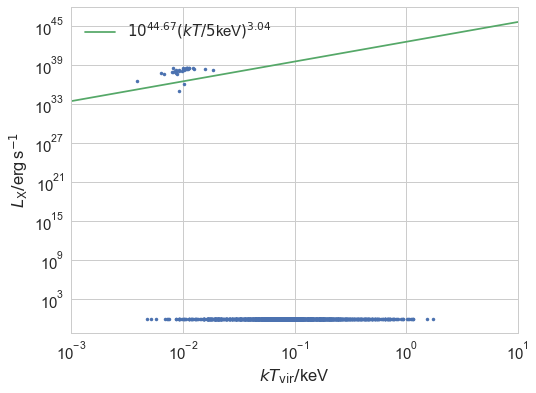

In [8]:
# Now make the plot
xmin=0.001
xmax=10.
pltFile='LxTx.png'
# matplotlib does not understand units, so need to make sure that we convert our
# physical quantities to the desired units before exporting:
x=kTvir.to(u.keV)
y=10**xrayLum_log10
plt.figure(0,figsize=(8,6))
plt.loglog(x,y,'.')
plt.xlabel(r'$kT_\mathrm{vir}/$keV')
plt.ylabel(r'$L_\mathrm{X}/$erg$\,$s$^{-1}$')
plt.xlim([xmin,xmax])
plt.plot(np.array([xmin,xmax]),10**44.67*(np.array([xmin,xmax])/5)**3.04,label=r'$10^{44.67}(kT/5$keV$)^{3.04}$')
plt.legend()
plt.savefig(pltFile)